### Notebook to print some example PFISR data for the paper

@author Riley Troyer
science@rileytroyer.com

In [4]:
# Libraries

from datetime import datetime as dt
from datetime import timedelta
from matplotlib import colors
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
from scipy.signal import find_peaks 
import sys

# Add root to path
path_root = Path('../../').resolve()
sys.path.append(str(path_root))

# Function to read in PFISR data
from src.data.pfisr_functions import get_isr_data

In [6]:
# Read in PFISR data
pfisr_dir = '../../data/raw/pfisr/'
date_str = '20161013'
#date_str = '20190903'

# Get filename
pfisr_filename = [f for f in os.listdir(pfisr_dir)
                  if date_str in f][0]

(pfisr_time,
 unix_time,
 pfisr_alt,
 e_density,
 de_density) = get_isr_data(pfisr_filename, pfisr_dir)

In [7]:
# Select data over specified altitude range
low_alt_cutoff = 60000

# Select only between 60km and 140km
altitude_slice = (pfisr_alt < 140000) & (pfisr_alt > low_alt_cutoff)
e_density = e_density[altitude_slice, :]
de_density = de_density[altitude_slice, :]
pfisr_alt = pfisr_alt[altitude_slice]

# Find lowest altitude boundary
lowest_alt = np.zeros(len(pfisr_time))
peak_alt = np.zeros(len(pfisr_time))
for n in range(0, len(pfisr_time)):
    
    # Select profile for time
    density_profile = e_density[:, n]
    
    # Get location of max peak
    peaks, properties = find_peaks(density_profile,
                                   height=1e10, prominence=(None, 5e9))
    if len(peaks) == 0:
        peak_alt[n] = np.nan
    else:
        peak_alt[n] = pfisr_alt[peaks[np.argmax(properties['peak_heights'])]]

    # Also get the profile for the error in this
    error_profile = de_density[:, n]
    
    # Select only densities > 10^10
    density_slice = density_profile >= 1e10
    
    # Select only densities with appropriate error
    error_slice = error_profile < 5e9
    
    # Select only densities that connect to points above
    continuity_slice = np.zeros(len(pfisr_alt), dtype=bool)

    for j in np.arange(len(pfisr_alt)):

        if j < (len(pfisr_alt) - 20):

            if ((np.min(density_profile[j+1:j+20]) > 0)
                & (np.median(density_profile[j-2:j+2]) 
                   < np.median(density_profile[j+1:j+20]))):
                continuity_slice[j] = True

            else:
                continuity_slice[j] = False

        else: 
            continuity_slice[j] = False
    
    # Account for possibly no density above threshold
    try:
        # Get lowest altitude value
        lowest_alt[n] = pfisr_alt[density_slice 
                                  & error_slice
                                  & continuity_slice][0]

    except:
        lowest_alt[n] = np.nan

/venvs/troyer-etal-2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/venvs/troyer-etal-2022/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


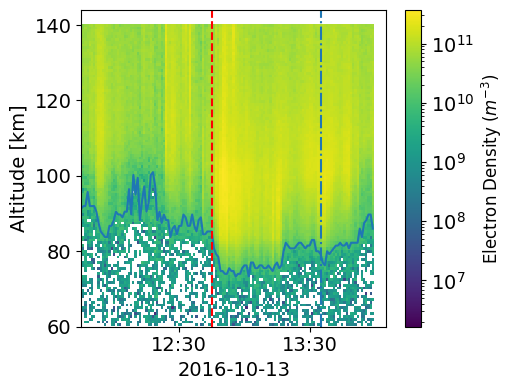

In [8]:
# Create a mesh to plot
time_mesh, altitude_mesh = np.meshgrid(pfisr_time, pfisr_alt)

start_time = dt(2016, 10, 13, 12, 45)
end_time = dt(2016, 10, 13, 14, 0)
date = start_time.date()

# Setup the plot
fig, ax = plt.subplots(figsize=(5.2, 4))

# plot colormesh
image = ax.pcolormesh(time_mesh, altitude_mesh/1000,
                      e_density,
                      norm=colors.LogNorm(), cmap='viridis',
                      shading='auto')

# Scatter lowest altitude
ax.plot(pfisr_time, lowest_alt/1000, color='C0',
        linewidth=1.5)
# ax.plot(pfisr_time, peak_alt/1000, color='C1',
#         linewidth=1.5)

# Set axis and ticks
ax.set_xlim(start_time - timedelta(hours=1),
            end_time + timedelta(minutes=5))
ax.set_ylim(60, 144)

# Plot times on x axis nicely
time_locator = mdates.MinuteLocator(byminute=[30],
                                    interval = 1)
ax.xaxis.set_minor_locator(time_locator)
h_fmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_locator(time_locator)
ax.xaxis.set_major_formatter(h_fmt)
ax.tick_params(labelsize=12)

ax.tick_params(axis='x', which='major', labelsize=14)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.set_ylabel('Altitude [km]', fontsize=14)
ax.set_xlabel(str(date), fontsize=14)

# Add PFISR colorplot
cbar = fig.colorbar(image, ax=ax)
cbar.set_label(r'Electron Density $(m^{-3}$)', fontsize=12)
cbar.ax.tick_params(labelsize=14)


# Finally add lines for start and stop of pulsating aurora
ax.axvline(start_time, color='red', linestyle='--')
ax.axvline(dt(2016, 10, 13, 13, 35), color='C0', linestyle='-.',
           linewidth=1.5)

plt.tight_layout()

# Save the figure
# plt.savefig('reports/figures/paper/'
#             + 'example-pfisr-for-paper.jpg', dpi=300)